In [1]:
from skimage.segmentation import clear_border
import pytesseract
import numpy as np
import imutils
import cv2
import matplotlib.pyplot as plt

def pyplot_image_show(image,cmap = 'gray',alpha = 1):
    plt.figure()
    plt.imshow(image,cmap=cmap,alpha = alpha)
    plt.title(str((image.min(),image.max())))
    
def concatenate_images(image1,image2,alpha_2):
    plt.figure()
    plt.imshow(image1, cmap='gray')
    plt.imshow(image2, alpha=alpha_2, cmap='gray')

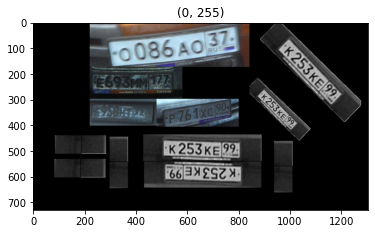

In [2]:
image_stock = cv2.imread("2020-12-08_21-05-20.jpg")
pyplot_image_show(image_stock)

In [3]:
class PyImageSearchANPR:
	def __init__(self, minAR=4, maxAR=5, debug=False):
		# store the minimum and maximum rectangular aspect ratio
		# values along with whether or not we are in debug mode
		self.minAR = minAR
		self.maxAR = maxAR
		self.debug = debug

	def debug_imshow(self, title, image,override = False, waitKey=False):
		# check to see if we are in debug mode, and if so, show the
		# image with the supplied title
		if (self.debug | override):
			cv2.imshow(title, image)

			# check to see if we should wait for a keypress
			if waitKey:
				cv2.waitKey(0)

	def locate_license_plate_candidates(self, gray, keep=16):
		# perform a blackhat morphological operation which will allow
		# us to reveal dark regions (i.e., text) on light backgrounds
		# (i.e., the license plate itself)
		rectKern = cv2.getStructuringElement(cv2.MORPH_RECT, (13*10, 5*10))
		blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, rectKern)
		self.debug_imshow("Blackhat", blackhat)

		# next, find regions in the image that are light
		squareKern = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
		light = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, squareKern)
		light = cv2.threshold(light, 0, 255,
			cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
		self.debug_imshow("Light Regions", light)

		# compute the Scharr gradient representation of the blackhat
		# image in the x-direction and then scale the result back to
		# the range [0, 255]
		gradX = cv2.Sobel(blackhat, ddepth=cv2.CV_32F,
			dx=1, dy=0, ksize=-1)
		gradX = np.absolute(gradX)
		(minVal, maxVal) = (np.min(gradX), np.max(gradX))
		gradX = 255 * ((gradX - minVal) / (maxVal - minVal))
		gradX = gradX.astype("uint8")
		self.debug_imshow("Scharr", gradX)

		# blur the gradient representation, applying a closing
		# operation, and threshold the image using Otsu's method
		gradX = cv2.GaussianBlur(gradX, (5, 5), 0)
		gradX = cv2.morphologyEx(gradX, cv2.MORPH_CLOSE, rectKern)
		thresh = cv2.threshold(gradX, 0, 255,
			cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
		self.debug_imshow("Grad Thresh", thresh)

		# perform a series of erosions and dilations to cleanup the
		# thresholded image
		thresh = cv2.erode(thresh, None, iterations=2)
		thresh = cv2.dilate(thresh, None, iterations=2)
		self.debug_imshow("Grad Erode/Dilate", thresh)

		# take the bitwise AND between the threshold result and the
		# light regions of the image
		thresh = cv2.bitwise_and(thresh, thresh, mask=light)
		thresh = cv2.dilate(thresh, None, iterations=2)
		thresh = cv2.erode(thresh, None, iterations=1)
		self.debug_imshow("Final", thresh, waitKey=True)

		# find contours in the thresholded image and sort them by
		# their size in descending order, keeping only the largest
		# ones
		cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
			cv2.CHAIN_APPROX_SIMPLE)
		cnts = imutils.grab_contours(cnts)
		cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:keep]

		# return the list of contours
		return cnts

	def locate_license_plate(self, gray, candidates,
		clearBorder=False):
		# initialize the license plate contour and ROI
		lpCnt = []
		roi = []

		# loop over the license plate candidate contours
		for c in candidates:
			# compute the bounding box of the contour and then use
			# the bounding box to derive the aspect ratio
			(x, y, w, h) = cv2.boundingRect(c)
			ar = w / float(h)

			# check to see if the aspect ratio is rectangular
			if ar >= self.minAR and ar <= self.maxAR:
				# store the license plate contour and extract the
				# license plate from the gray scale image and then
				# threshold it
				lpCnt.append(c)
				licensePlate = gray[y:y + h, x:x + w]
				roi.append( cv2.threshold(licensePlate, 0, 255,
					cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1])
                

				# check to see if we should clear any foreground
				# pixels that are touching the border of the image
				# (which typically, not but always, indicates noise)
				if clearBorder:
					roi = clear_border(roi)

				# display any debugging information and then break
				# from the loop early since we have found the license
				# plate region
				self.debug_imshow("License Plate", licensePlate,override=False)
				self.debug_imshow("ROI", roi, waitKey=True,override = False)
				

		# return a 2-tuple of the license plate ROI and the contour
		# associated with it
		return (roi, lpCnt)

	def find_and_ocr(self, image, psm=7, clearBorder=False):
		# initialize the license plate text
		lpText = None

		# convert the input image to grayscale, locate all candidate
		# license plate regions in the image, and then process the
		# candidates, leaving us with th *actual* license plate
		gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
		candidates = self.locate_license_plate_candidates(gray)
		(lp, lpCnt) = self.locate_license_plate(gray, candidates,
			clearBorder=clearBorder)
		#print(lpCnt)

		# only OCR the license plate if the license plate ROI is not
		# empty
		

		# return a 2-tuple of the OCR'd license plate text along with
		# the contour associated with the license plate region
		return lpCnt

3


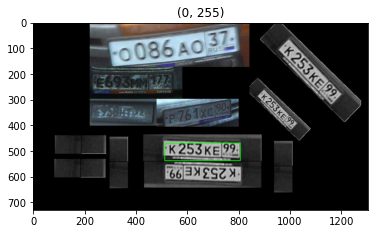

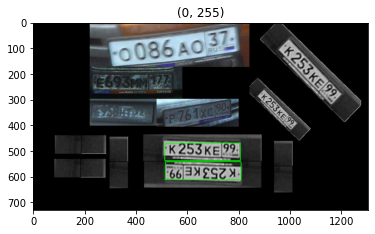

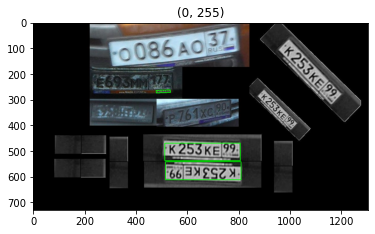

In [4]:
lps = PyImageSearchANPR(4,5,debug=False)
lpCnt = lps.find_and_ocr(image_stock)
for i in lpCnt:
    box = cv2.boxPoints(cv2.minAreaRect(i))
    box = box.astype("int")
    #print(box)
    cv2.drawContours(image_stock, [box], -1, (0, 255, 0), 2)

    # compute a normal (unrotated) bounding box for the license
    # plate and then draw the OCR'd license plate text on the
    # image
    pyplot_image_show(image_stock)
    #cv2.polylines(image_stock,box,True,(0,0,0))
    #cv2.rectangle(image_stock,)
    #cv2.imshow("Output ANPR", image_stock)
print(len(lpCnt))